In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [3]:
# 1. Load train & test
train = pd.read_csv('data/application_train.csv')
test  = pd.read_csv('data/application_test.csv')

print(train.columns.tolist())
print(test.columns.tolist())

# Direct protected class features:
['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# Indirect proxies:
['OWN_CAR_AGE','CNT_CHILDREN']

# Suspicious:
['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [4]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 119 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,36613,69.9
COMMONAREA_MEDI,36613,69.9
COMMONAREA_MODE,36613,69.9
NONLIVINGAPARTMENTS_MODE,36370,69.4
NONLIVINGAPARTMENTS_MEDI,36370,69.4
NONLIVINGAPARTMENTS_AVG,36370,69.4
LIVINGAPARTMENTS_AVG,35855,68.4
LIVINGAPARTMENTS_MEDI,35855,68.4
LIVINGAPARTMENTS_MODE,35855,68.4
FONDKAPREMONT_MODE,35815,68.3


In [5]:
# 2. Fix DAYS_EMPLOYED anomaly
train['DAYS_EMPLOYED_ANOM'] = (train['DAYS_EMPLOYED'] == 365243).astype(int)
test['DAYS_EMPLOYED_ANOM']  = (test['DAYS_EMPLOYED'] == 365243).astype(int)

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({365243: np.nan})
test['DAYS_EMPLOYED']  = test['DAYS_EMPLOYED'].replace({365243: np.nan})

In [6]:
# 3. Drop the same columns from train & test BEFORE encoding
cols_to_drop = [
    "SK_ID_CURR",
    "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START",
    "WALLSMATERIAL_MODE", "N"
]

# biased_cols = ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE','CNT_CHILDREN']
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

train.drop(columns=cols_to_drop, errors="ignore", inplace=True)
test.drop(columns=cols_to_drop, errors="ignore", inplace=True)


In [7]:
def preprocess_and_encode(train_df, test_df, target_col="TARGET"):
    """
    Returns:
        X_enc, X_test_enc, y, feature_names, ct
    """
    import pandas as pd
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

    # 1. Split target
    y = train_df[target_col]
    train_X = train_df.drop(columns=[target_col])

    # 2. Align train/test
    train_X, test_X = train_X.align(test_df, join="inner", axis=1)

    # 3. Identify categorical columns
    one_hot_cols = [
        'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
        'EMERGENCYSTATE_MODE'
    ]

    # Keep only those present
    one_hot_cols = [c for c in one_hot_cols if c in train_X.columns]

    # 4. Split binary vs multi
    binary_cats = []
    multi_cats = []

    for col in one_hot_cols:
        unique_vals = train_X[col].dropna().unique()
        if len(unique_vals) <= 2:
            binary_cats.append(col)
        else:
            multi_cats.append(col)

    # 5. Build ColumnTransformer
    ct = ColumnTransformer(
        transformers=[
            ("binary", OrdinalEncoder(), binary_cats),
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cats),
        ],
        remainder="passthrough"
    )

    # 6. Fit/transform
    X_enc = ct.fit_transform(train_X)
    X_test_enc = ct.transform(test_X)

    feature_names = ct.get_feature_names_out()

    return X_enc, X_test_enc, y, feature_names, ct

def make_numeric_for_corr(df):
    df_corr = df.copy()
    for col in df_corr.columns:
        # Convert objects/categories to integer codes for correlation
        if df_corr[col].dtype == 'object' or str(df_corr[col].dtype).startswith('category'):
            df_corr[col] = df_corr[col].astype('category').cat.codes
    return df_corr



In [8]:
# Prepare biased versions (original)
train_biased = train.copy()
test_biased = test.copy()

biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

# Prepare unbiased versions
# train_unbiased = train.copy()
# test_unbiased = test.copy()

train_corr = make_numeric_for_corr(train)
corr = train_corr.corr()

valid_bcols = [b for b in biased_cols if b in corr.columns]

corr_sub = corr[valid_bcols]

corr['CODE_GENDER'].sort_values(ascending=False)[:10]

cutoff = 0.1

biased_proxies = []
proxy_features = set()
proxy_features = proxy_features - set(valid_bcols)


for bcol in valid_bcols:
    # Identify features whose absolute correlation exceeds the cutoff
    high_corr_features = corr.index[corr[bcol].abs() > cutoff].tolist()

    # Add them to the proxy set
    proxy_features.update(high_corr_features)

proxy_features = proxy_features - set(valid_bcols)

for bcol in valid_bcols:
    subset = corr[bcol].abs().sort_values(ascending=False)
    subset = subset.drop(labels=bcol, errors='ignore')
    biased_proxies.append(subset)

biased_table = pd.concat(biased_proxies, axis=1)
biased_table.columns = valid_bcols        # MATCHING LENGTH
biased_table = biased_table.fillna(0)
biased_table.sort_values(by=valid_bcols, ascending=False, inplace=True)

print(biased_table.head())

print(proxy_features)
print(f"{len(proxy_features)} proxy features identified.")
print(f"This is {(len(proxy_features) / len(train_biased.columns)) * 100:.2f}% of the total.")

                    CODE_GENDER  DAYS_BIRTH
FLAG_OWN_CAR           0.349542    0.125258
EXT_SOURCE_1           0.310977    0.600659
FLAG_DOCUMENT_8        0.249362    0.113839
ORGANIZATION_TYPE      0.162312    0.395209
DAYS_EMPLOYED_ANOM     0.156492    0.617716
{'NAME_INCOME_TYPE', 'EXT_SOURCE_3', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'FLAG_DOCUMENT_8', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'FLAG_DOCUMENT_6', 'EXT_SOURCE_1', 'FLAG_OWN_CAR', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED_ANOM', 'REG_CITY_NOT_LIVE_CITY', 'DAYS_REGISTRATION', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'DAYS_ID_PUBLISH', 'FLAG_OWN_REALTY'}
25 proxy features identified.
This is 21.01% of the total.


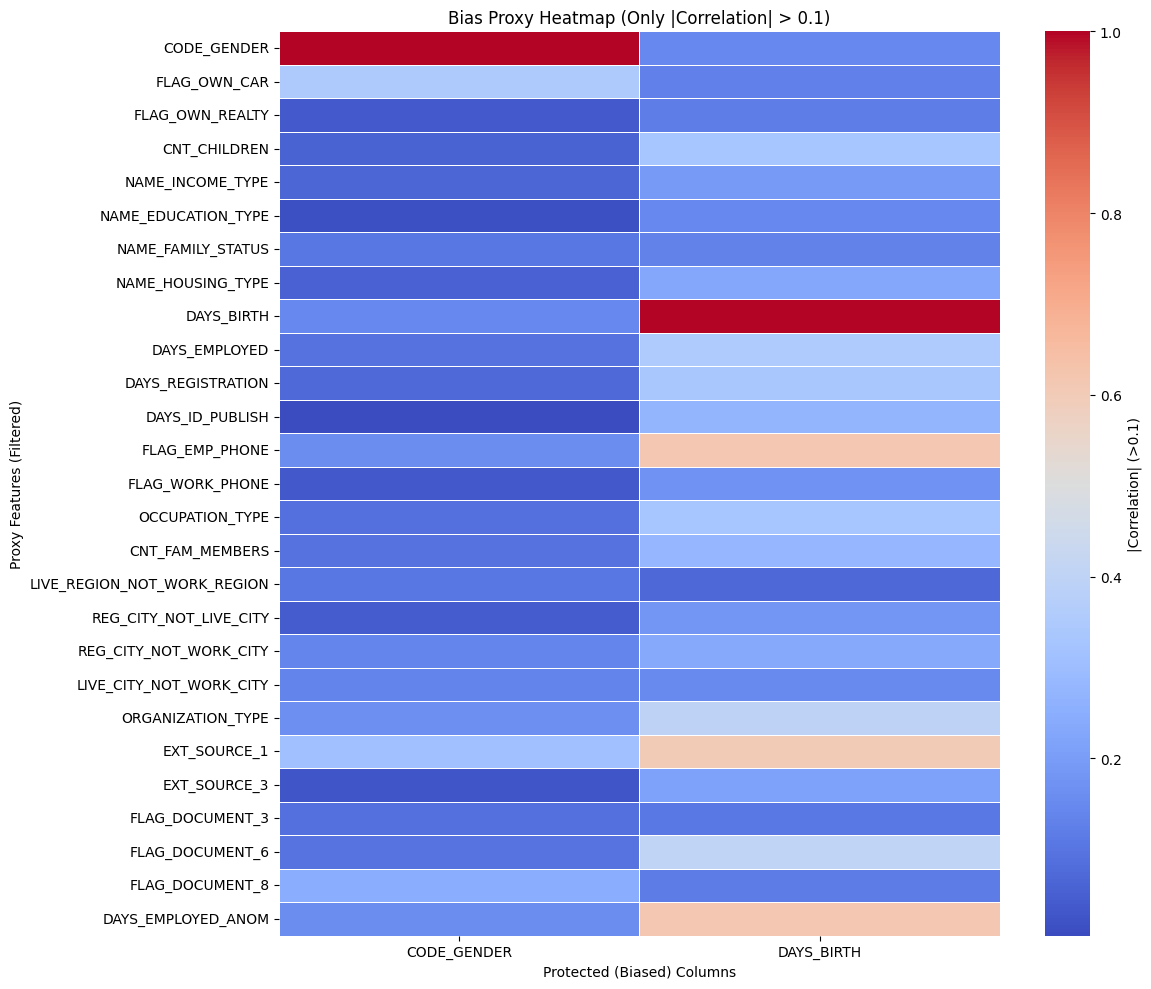

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# corr_sub = corr[valid_bcols]  # Ensure corr_sub already exists

# 1. Identify features with correlation > cutoff with ANY biased column
mask = corr_sub.abs().max(axis=1) > cutoff

# 2. Filter correlation matrix to only proxy features
corr_filtered = corr_sub[mask]

# 3. Plot heatmap of only high-correlation proxy features
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_filtered.abs(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    cbar_kws={'label': f'|Correlation| (>{cutoff})'}
)

plt.title(f"Bias Proxy Heatmap (Only |Correlation| > {cutoff})")
plt.xlabel("Protected (Biased) Columns")
plt.ylabel("Proxy Features (Filtered)")
plt.tight_layout()
plt.show()


So there are a lot of features that are correlated with gender and age. However, if we were to drop all of these features, our model would not be very accurate. To solve this problem, we will run an overlap test to identify features that can cause a positivity violation with our protected classes of gender and age.

In [10]:
#  0. Convert categorical to numeric for correlation & overlap
train_corr = make_numeric_for_corr(train)

#  1. Define protected variables
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']   # core sensitive features

#  2. Create Gender Binary (0 = M, 1 = F)
train['_GENDER_BIN'] = (train['CODE_GENDER'] == 'F').astype(int)

#  3. Create Age Group Bins for positivity testing
# DAYS_BIRTH is negative in Home Credit, so invert it:
train['_AGE'] = -train['DAYS_BIRTH']

# Use quartiles for overlap testing
train['_AGE_BIN'] = pd.qcut(train['_AGE'], q=4, labels=False, duplicates='drop')

#  4. Define candidate (non-protected) features
protected_vars = biased_cols + ['_GENDER_BIN', '_AGE_BIN', '_AGE']

candidate_features = [
    c for c in train.columns
    if c not in protected_vars and c not in ['TARGET']
]

print("Number of candidate features:", len(candidate_features))


#  5. POSITIVITY TEST FOR GENDER (M vs F)

female_unique = train.loc[train['_GENDER_BIN'] == 1, candidate_features].nunique()
viol_female = list(female_unique[female_unique < 2].index)

male_unique   = train.loc[train['_GENDER_BIN'] == 0, candidate_features].nunique()
viol_male = list(male_unique[male_unique < 2].index)

print("\n Gender Positivity Violations ")
print("Violates for FEMALES:", viol_female)
print("Violates for MALES:", viol_male)


#  6. POSITIVITY TEST FOR AGE (each age bin)

viol_age_bins = {}

for age_group in sorted(train['_AGE_BIN'].dropna().unique()):
    gmask = train['_AGE_BIN'] == age_group
    nunique_vals = train.loc[gmask, candidate_features].nunique()
    viol = list(nunique_vals[nunique_vals < 2].index)
    viol_age_bins[int(age_group)] = viol

print("\n Age Positivity Violations ")
for k, v in viol_age_bins.items():
    print(f"Age bin {k}: {v}")


#  7. Combine all violations

positivity_violations = set(viol_female) | set(viol_male)

for vlist in viol_age_bins.values():
    positivity_violations |= set(vlist)

positivity_violations = sorted(positivity_violations)

print("\n ALL Positivity Violations Across Gender + Age ")
print(positivity_violations)


Number of candidate features: 116

 Gender Positivity Violations 
Violates for FEMALES: ['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12']
Violates for MALES: []

 Age Positivity Violations 
Age bin 0: ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12']
Age bin 1: ['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12']
Age bin 2: ['FLAG_MOBIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_21']
Age bin 3: ['FLAG_MOBIL', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_21']

 ALL Positivity Violations Across Gender + Age 
['FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_21', 'FLAG_MOBIL']


This is a very interesting result. The test we just ran studied the dataset for positivity (overlap) violations. In the certain protected groups, these two features showed no variability. For females for example, the FLAG_MOBIL variable always has the same result. This flag also presents itself as an age-related bias. With a lack of variability, these features still reinforce structural bias and undermine the fairness adjusted modeling technique.

In [11]:
# Last step: Drop all the biased columns from the unbiased set

all_biased_to_drop = set(biased_cols) | set(proxy_features) | set(positivity_violations)

print("Dropping these biased features:", all_biased_to_drop)

train_unbiased = train.drop(columns=all_biased_to_drop)
test_unbiased = test.drop(columns=all_biased_to_drop)

print(f"Dropped {len(all_biased_to_drop)} features. This is {(len(all_biased_to_drop) / len(train_biased.columns)) * 100:.2f}% of the original.")


Dropping these biased features: {'NAME_INCOME_TYPE', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_12', 'EXT_SOURCE_3', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_10', 'DAYS_BIRTH', 'CNT_CHILDREN', 'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_8', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'FLAG_DOCUMENT_6', 'EXT_SOURCE_1', 'FLAG_OWN_CAR', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED_ANOM', 'REG_CITY_NOT_LIVE_CITY', 'CODE_GENDER', 'DAYS_REGISTRATION', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'DAYS_ID_PUBLISH', 'FLAG_OWN_REALTY'}
Dropped 33 features. This is 27.73% of the original.


It is important to note that most columns dropped here explode the dimensionality when the data is one-hot encoded.

In [12]:
# Run biased pipeline
X_biased_enc, X_test_biased_enc, y_biased, feature_names_biased, ct_biased = \
    preprocess_and_encode(train_biased, test_biased)

print("Biased train shape:", X_biased_enc.shape)
print("Biased test shape:", X_test_biased_enc.shape)

# Run unbiased pipeline
X_unbiased_enc, X_test_unbiased_enc, y_unbiased, feature_names_unbiased, ct_unbiased = \
    preprocess_and_encode(train_unbiased, test_unbiased)

print("Unbiased train shape:", X_unbiased_enc.shape)
print("Unbiased test shape:", X_test_unbiased_enc.shape)

Biased train shape: (52406, 236)
Biased test shape: (48744, 236)
Unbiased train shape: (52406, 99)
Unbiased test shape: (48744, 99)


# Training Biased and Unbiased Models

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
import seaborn as sns
from sklearn.model_selection import cross_val_predict

def scores(y_true, y_pred, y_pred_proba, title="Model Evaluation"):
    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Print metric summary
    print(f"{title}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC-AUC:", auc)
    print("\nConfusion Matrix (Raw Values):\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In [14]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

In [1]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [15]:
spark = SparkSession.builder.getOrCreate()


What I will eventually do is quantify how much the feature input weights in the model that has more features has on the output by directly comparing the two models. I will then need a vector which quantifies and tells the BIASED model how to adjust the weight of the input features to be unbiased, and the same for the inverse task (make an unbiased model biased).

Model Evaluation (Biased – Spark RF)
Accuracy: 0.9199180647678502
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC-AUC: 0.7373847178513444

Confusion Matrix (Raw Values):
 [[9431    0]
 [ 821    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


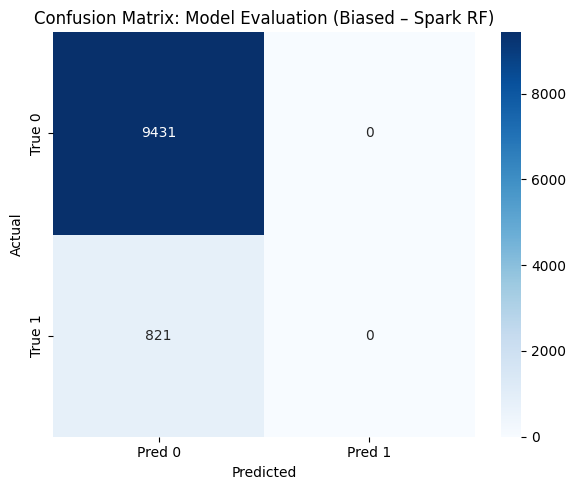

In [17]:
# ==== Spark ML Random Forest on BIASED encoded data ====

label_col = "TARGET"

# 1) Wrap encoded arrays into pandas
biased_train_pdf = pd.DataFrame(X_biased_enc, columns=feature_names_biased)
biased_train_pdf[label_col] = y_biased.values

biased_test_pdf = pd.DataFrame(X_test_biased_enc, columns=feature_names_biased)

# median imputation to remove NaNs (train medians used for both)
train_medians = biased_train_pdf[feature_names_biased].median(numeric_only=True)

biased_train_pdf[feature_names_biased] = biased_train_pdf[feature_names_biased].fillna(train_medians)
biased_test_pdf[feature_names_biased]  = biased_test_pdf[feature_names_biased].fillna(train_medians)

# 1b) Now convert to Spark DataFrames
biased_train_sdf = spark.createDataFrame(biased_train_pdf)
biased_test_sdf  = spark.createDataFrame(biased_test_pdf)

# 2) Train/validation split (Spark equivalent of CV here)
train_sdf, val_sdf = biased_train_sdf.randomSplit([0.8, 0.2], seed=42)

# 3) Spark ML pipeline: VectorAssembler + RandomForest
assembler_biased = VectorAssembler(
    inputCols=feature_names_biased.tolist(),  # all encoded features
    outputCol="features",
    handleInvalid="keep"
)

rf_biased = RandomForestClassifier(
    labelCol=label_col,
    featuresCol="features",
    numTrees=50,
    maxDepth=6,
    featureSubsetStrategy="sqrt",
    seed=42
)

rf_pipeline_biased = Pipeline(stages=[assembler_biased, rf_biased])

# 4) Fit on train split and evaluate on validation
rf_model_biased = rf_pipeline_biased.fit(train_sdf)
val_pred_biased = rf_model_biased.transform(val_sdf)

# Convert val predictions to pandas to reuse your scores() function
val_pd_biased = val_pred_biased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")  # P(y=1)
).toPandas()

val_pd_biased["y_pred"] = (val_pd_biased["p"] >= 0.5).astype(int)

scores(
    val_pd_biased["y"],
    val_pd_biased["y_pred"],
    val_pd_biased["p"],
    title="Model Evaluation (Biased – Spark RF)"
)

# 5) Train final RF on all biased training data
rf_final_biased = rf_pipeline_biased.fit(biased_train_sdf)

# 6) Predict on biased test data (Spark equivalent of lgbm_test_pred)
test_pred_biased = rf_final_biased.transform(biased_test_sdf)

test_pd_biased = test_pred_biased.select(
    vector_to_array("probability")[1].alias("TARGET_PROB")
).toPandas()

rf_biased_test_pred = test_pd_biased["TARGET_PROB"].values  # same role as lgbm_test_pred


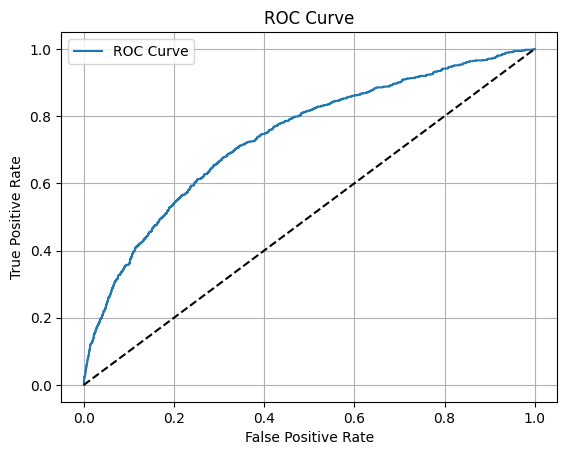

In [24]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ---- Extract true labels + probabilities ----
pdf = val_pred_biased.select(
    col("TARGET").alias("y"),
    vector_to_array("probability")[1].alias("p")   # P(y=1)
).toPandas()

# ---- Compute ROC curve ----
fpr, tpr, _ = roc_curve(pdf["y"], pdf["p"])

# ---- Plot ----
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Model Evaluation (Unbiased – Spark RF)
Accuracy: 0.9203849518810149
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC-AUC: 0.6385221242635691

Confusion Matrix (Raw Values):
 [[1052    0]
 [  91    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


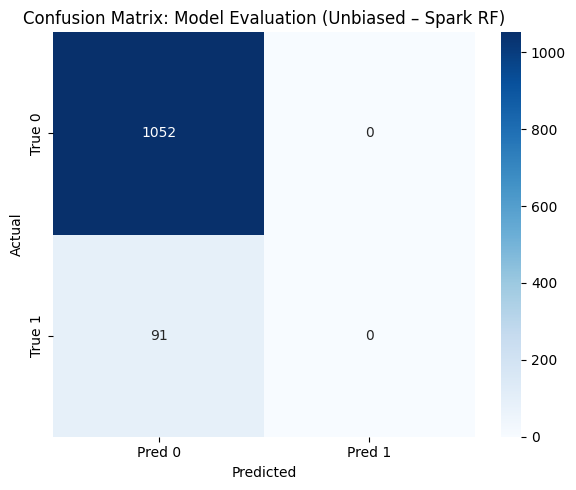

In [21]:
# ==== Spark ML Random Forest on UNBIASED encoded data ====

label_col = "TARGET"

# 1) Wrap encoded arrays into pandas
unbiased_train_pdf = pd.DataFrame(X_unbiased_enc, columns=feature_names_unbiased)
unbiased_train_pdf[label_col] = y_unbiased.values

unbiased_test_pdf = pd.DataFrame(X_test_unbiased_enc, columns=feature_names_unbiased)

# Median imputation to remove NaNs (use train medians for both)
train_medians_unbiased = unbiased_train_pdf[feature_names_unbiased].median(numeric_only=True)

unbiased_train_pdf[feature_names_unbiased] = unbiased_train_pdf[feature_names_unbiased].fillna(
    train_medians_unbiased
)
unbiased_test_pdf[feature_names_unbiased] = unbiased_test_pdf[feature_names_unbiased].fillna(
    train_medians_unbiased
)

# 2) Convert to Spark DataFrames
unbiased_train_sdf = spark.createDataFrame(unbiased_train_pdf)
unbiased_test_sdf  = spark.createDataFrame(unbiased_test_pdf)

# 3) Train/validation split (Spark equivalent of CV here)
train_sdf_u, val_sdf_u = unbiased_train_sdf.randomSplit([0.8, 0.2], seed=42)

# 4) Spark ML pipeline: VectorAssembler + RandomForest
assembler_unbiased = VectorAssembler(
    inputCols=feature_names_unbiased.tolist(),  # all encoded features (unbiased)
    outputCol="features",
    handleInvalid="keep"
)

rf_unbiased = RandomForestClassifier(
    labelCol=label_col,
    featuresCol="features",
    numTrees=50,
    maxDepth=6,
    featureSubsetStrategy="sqrt",
    seed=42
)

rf_pipeline_unbiased = Pipeline(stages=[assembler_unbiased, rf_unbiased])

# 5) Fit on train split and evaluate on validation
rf_model_unbiased = rf_pipeline_unbiased.fit(train_sdf_u)
val_pred_unbiased = rf_model_unbiased.transform(val_sdf_u)

# Convert val predictions to pandas to reuse your scores() function
val_pd_unbiased = val_pred_unbiased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")  # P(y=1)
).toPandas()

val_pd_unbiased["y_pred"] = (val_pd_unbiased["p"] >= 0.5).astype(int)

scores(
    val_pd_unbiased["y"],
    val_pd_unbiased["y_pred"],
    val_pd_unbiased["p"],
    title="Model Evaluation (Unbiased – Spark RF)"
)

# 6) Train final RF on all unbiased training data
rf_final_unbiased = rf_pipeline_unbiased.fit(unbiased_train_sdf)

# 7) Predict on unbiased test data
test_pred_unbiased = rf_final_unbiased.transform(unbiased_test_sdf)

test_pd_unbiased = test_pred_unbiased.select(
    vector_to_array("probability")[1].alias("TARGET_PROB")
).toPandas()

rf_unbiased_test_pred = test_pd_unbiased["TARGET_PROB"].values
